In [85]:
import numpy as np
import tensorflow as tf
import sklearn
import sys
import matplotlib.pyplot as plt
from tensorflow import keras
print(tf.__version__)
print(sys.version)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

2.5.0
3.8.8 (default, Apr 13 2021, 19:58:26) 
[GCC 7.3.0]


本文主要介绍tensorflow中关于CNN的一些基础功能。

## 1、滤波器与特征图

我们先看一下图画经过滤波器后输出的特征图。

我们定义了2个7*7的滤波器，第一个的中间竖线为1，其余部分为0；第二个滤波器的中间横线为1，其余部分为0。
特征图上每一点的数值等于其对应的7*7图象的加权求和，而由于第一个滤波器除中间竖线以外的数值都为0，所以特征图的数值输出只与中间的7个点相关。所以对于第一个滤波器，白色竖线被加强了，而其余部分变得模糊。同理，对于第二个滤波器，白色横线被加强了，其余部分变得模糊。

注意，这里为了展示滤波器的作用，我们自己定义了一个滤波器。而在模型训练中，滤波器的权重一般是可训练的。

2 427 640 3


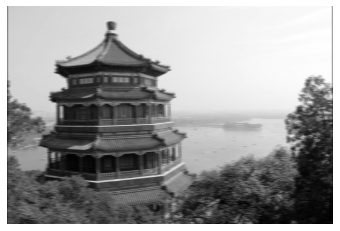

In [86]:
# 加载图片
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
print(batch_size, height, width, channels)

# 创建2个滤波器
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 #垂直滤波器
filters[3, :, :, 1] = 1 #水平滤波器

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0,:,:,1], cmap="gray")
plt.axis('off')
plt.show()


让我们看一下这段代码：
* 每个颜色通道的像素强度表示为从0到255的字节，因此我们除以255即可缩放这些特征，得到从0到1的浮点数。
* 然后，我们创建两个7×7的滤波器（一个在中间带有垂直白线，另一个在中间带有水平白线）。
* 我们使用tf.nn.conv2d()函数应用于两个图像，这是TensorFlow的低层深度学习API的一部分。在此示例中，我们使用零填充（padding="SAME"）和步幅为1。
* 最后，绘制一个结果特征图。

f.nn.conv2d（）行值得更多解释：
* images是输入的小批量（4D张量，如前所述）。
* filter是要应用的一组滤波器（也是4D张量，如前所述）。
* strides等于1，但也可以是包含四个元素的一维度组，其中两个中间元素是垂直步幅和水平步幅（sh和sw）。第一个元素和最后一个元素必须等于1。它们可能有一天用于指定批处理步幅（跳过某些实例）和通道步幅（跳过某些上一层的特征图或通道）。
* padding必须为"SAME"或"VALID"：
* 如果设置为"SAME"，则卷积层在必要时使用零填充。将输出大小设置为输入神经元的数量除以步幅（向上取整）所得的值。例如，如果输入大小为13而步幅为5，则输出大小为3（即13/5=2.6，向上舍入为3）。然后根据需要在输入周围尽可能均匀地添加零。当strides=1时，层的输出将具有与其输入相同的空间尺寸（宽度和高度），因此命名为“same”。
* 如果设置为"VALID"，则卷积层将不使用零填充，并且可能会忽略输入图像底部和右侧的某些行和列，具体取决于步幅，（为简单起见，仅这里显示了水平尺寸，当然垂直尺寸也适用相同的逻辑。这意味着每个神经元的接受野都严格位于输入内部的有效位置内（不会超出范围），因此命名为“valid”。

![](https://lujinhong-markdown.oss-cn-beijing.aliyuncs.com/md/截屏.png)
此示例中，我们手动定义了滤波器，但是在实际的CNN中，你通常将滤波器定义为可训练变量，以便神经网络可以了解哪种滤波器效果最好。

下面我们把4个特征图都画出来：

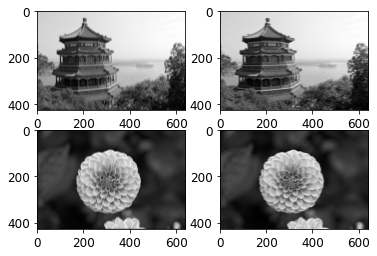

In [87]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index*2+feature_map_index+1)
        plt.imshow(outputs[image_index, :, :, feature_map_index], cmap='gray')

plt.show()

我们对看一下图像的局部：

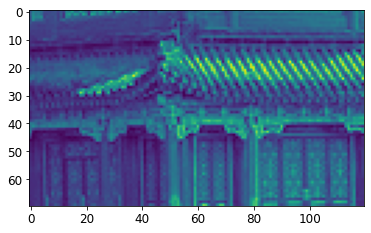

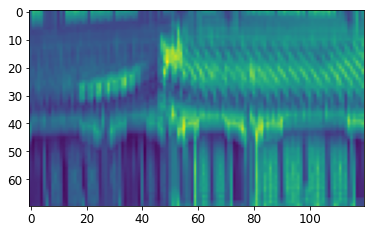

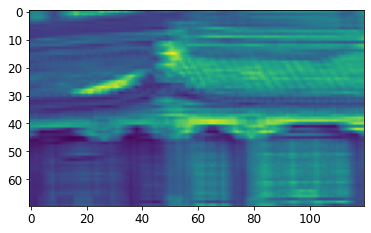

In [88]:
def crop(images):
    return images[150:220, 130:250]

plt.imshow(crop(images[0, :, :, 0]))
#save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plt.imshow(crop(outputs[0, :, :, feature_map_index]))
    #save_fig(filename, tight_layout=False)
    plt.show()

最后，我们画一下上面的那2个滤波器：

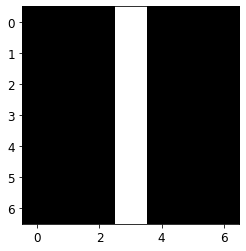

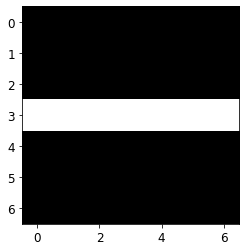

In [89]:
plt.imshow(filters[:, :, 0, 0], cmap='gray')
plt.show()
plt.imshow(filters[:, :, 0, 1], cmap='gray')
plt.show()

### 卷积层
正如上面所言，在实际的CNN中，你通常将滤波器定义为可训练变量，以便神经网络可以了解哪种滤波器效果最好，如前所述。不用手动创建变量，使用keras.layers.Conv2D层。

这段代码使用步幅为1（水平和垂直）和"same"的填充，创建了一个包含32个滤波器（每个3×3）的Conv2D层，并将ReLU激活函数应用于其输出。如你所见，卷积层具有很多超参数：你必须选择滤波器的数量、其高度和宽度、步幅和填充类型。与往常一样，你可以使用交叉验证来找到正确的超参数值，但这非常耗时。稍后我们将讨论通用的CNN架构，使你了解哪些超参数值在实践中最有效。

In [90]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

## 2、池化层



池化层的目标是对输入图像进行下采样（即缩小），以便减少计算量、内存使用量和参数数量（从而降低过拟合的风险）。

就像在卷积层中一样，池化层中的每个神经元都连接到位于一个小的矩形接受野中的上一层中有限数量的神经元的输出。你必须像以前一样定义其大小、步幅和填充类型。但是，池化神经元没有权重。它所做的全部工作就是使用聚合函数（例如最大值或均值）来聚合输入。图148显示了最大池化层，它是最常见的池化层类型。在此示例中，我们使用2×2池化内核，步幅为2，没有填充。只有每个接受野中的最大输入值才能进入下一层，而其他输入则被丢弃。例如，在图148的左下接受野中，输入值为1、5、3、2，因此只有最大值5传播到下一层。由于步幅为2，因此输出图像的高度为输入图像的一半，宽度为输入图像的一半（由于不使用填充，因此四舍五入）。

![](https://lujinhong-markdown.oss-cn-beijing.aliyuncs.com/md/截屏3.png)

池化层通常独立地作用于每个输入通道，因此输出深度与输入深度相同。

### 不变性

除了减少计算量、内存使用量和参数数量之外，最大池化层还为小变换引入了一定程度的不变性，如图149所示。在这里，我们假设亮像素的值比暗像素的值低，并且我们考虑三个图像（A，B，C）经过最大池化层，其内核为2×2，步幅为2。图像B和C与图片A相同，但向右移动一两个像素。如你所见，图像A和B的最大池化层的输出是相同的。这就是变换不变性的含义。对于图像C，输出是不同的：它向右移动了一个像素（但仍然有75％的不变性）。通过在CNN中每隔几层插入一个最大池化层，就可以在更大范围内获得某种程度的变换不变性。而且最大池化提供了少量的旋转不变性和轻微的尺度不变性。在不应该依赖这些细节的预测情况下（例如在分类任务中），这种不变性（即使有局限性）也很有用。

![](https://lujinhong-markdown.oss-cn-beijing.aliyuncs.com/md/截屏4.png)


要创建平均池化层，只需使用AvgPool2D而不是MaxPool2D。如你所料，它的工作原理与最大池化层完全相同，只是它计算的是平均值而不是最大值。平均池化层曾经很受欢迎，但是现在人们通常都使用最大池化层，因为它们通常表现更好。这似乎令人惊讶，因为计算均值通常比计算最大值损失更少的信息。但是另一方面，最大池化仅保留最强的特征，将所有无意义的特征都丢弃掉，因此下一层可获得更清晰的信号来使用。而且与平均池化相比，最大池化提供了更强的变换不变性，并且所需计算量略少于平均池化。

在现代架构中经常会看到的最后一种类型的池化层是全局平均池化层。它的工作原理非常不同：它所做的是计算整个特征图的均值（这就像使用与输入有相同空间维度的池化内核的平均池化层）。这意味着它每个特征图和每个实例只输出一个单值。尽管这是极具破坏性的（特征图中的大多数信息都丢失了），但它可以用作输出层，正如我们将在本章稍后看到的那样。要创建这样的层，只需使用keras.layers.GlobalAvgPool2D类。

In [91]:
max_pool=keras.layers.MaxPool2D(pool_size=2)
max_pool=keras.layers.AvgPool2D(pool_size=2)
global_avg_pool=keras.layers.GlobalAvgPool2D()

### 最大池化层

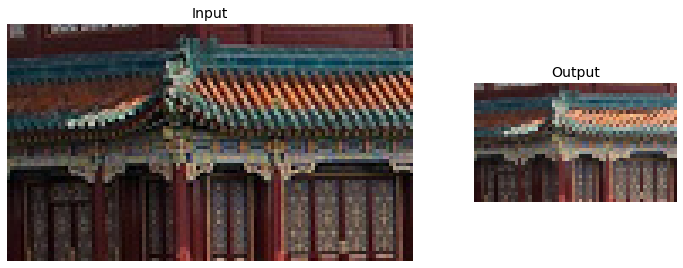

In [92]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### 平均池化层

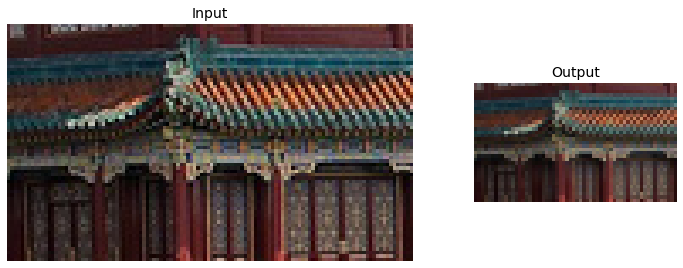

In [93]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

### 全局平均池化层

In [94]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## 3、使用CNN对fashion mnist分类

In [95]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
print(X_train.size, X_valid.size)

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

43120000 3920000
Epoch 1/10
1719/1719 [==============================] - 56s 32ms/step - loss: 0.6978 - accuracy: 0.7557 - val_loss: 0.3627 - val_accuracy: 0.8654
Epoch 2/10
1719/1719 [==============================] - 54s 31ms/step - loss: 0.4073 - accuracy: 0.8631 - val_loss: 0.3414 - val_accuracy: 0.8804
Epoch 3/10
1719/1719 [==============================] - 53s 31ms/step - loss: 0.3599 - accuracy: 0.8790 - val_loss: 0.3047 - val_accuracy: 0.8918
Epoch 4/10
1719/1719 [==============================] - 54s 31ms/step - loss: 0.3271 - accuracy: 0.8902 - val_loss: 0.2911 - val_accuracy: 0.8914
Epoch 5/10
1719/1719 [==============================] - 54s 31ms/step - loss: 0.3018 - accuracy: 0.8967 - val_loss: 0.2815 - val_accuracy: 0.8960
Epoch 6/10
1719/1719 [==============================] - 54s 31ms/step - loss: 0.2843 - accuracy: 0.9025 - val_loss: 0.2854 - val_accuracy: 0.8944
Epoch 7/10
1719/1719 [==============================] - 54s 32ms/step - loss: 0.2730 - accuracy: 0.9080 - v

让我们看一下这个模型：
* 第一层使用64个相当大的滤波器（7×7），但没有步幅，因为输入图像不是很大。设置了input_shape=[28，28，1]，因为图像是28×28像素，具有单个颜色通道（即灰度）。
* 接下来，我们有一个最大池化层，池化大小为2，因此它将每个空间维度除以2。
* 然后我们重复相同的结构两次：两个卷积层，紧接着是一个最大池化层。对于较大的图像，我们可以重复多次此结构（重复次数是你可以调整的超参数）。
* 请注意随着CNN向输出层延伸，滤波器的数量会增加（最初是64，然后是128，然后是256）：增长是有意义的，因为低层特征的数量通常很少（例如小圆圈、水平线），但是有很多不同的方法可以将它们组合成更高层次的特征。通常的做法是在每个池化层之后将滤波器的数量加倍：由于池化层将每个空间维度除以2，所以我们能负担得起对下一层特征图数量加倍而不必担心参数数量、内存使用量或计算量的暴增。
* 接下来是全连接的网络，该网络由两个隐藏的密集层和一个密集输出层组成。请注意，我们必须将其输入展平，因为密集网络需要每个实例的一维特征阵列。我们还添加了两个dropout层，每层的dropout率均为50％，以减少过拟合的情况。

该CNN在测试集上的精度达到90％以上。它不是最好的，但是也相当不错，显然比我们在第10章中使用密集网络获得的结果要好得多。



## 4、使用keras的预训练模型
通常，你无须手动实现像GoogLeNet或ResNet这样的标准模型，因为在keras.applications包中只需一行代码即可轻松获得预训练的网络。

下面我们使用预训练的ResNet-50模型，对我们的图片进行分类预测：

In [96]:
model = keras.applications.resnet50.ResNet50(weights='imagenet')
images_resized = tf.image.resize(images, [224, 224])
inputs = keras.applications.resnet50.preprocess_input(images_resized*255)
Y_proba = model.predict(inputs)
print(Y_proba)

[[2.0904542e-08 6.2080815e-08 3.4869107e-08 ... 3.0669500e-09
  1.3305230e-07 8.0237314e-08]
 [5.9631894e-08 4.5336081e-05 2.2300486e-07 ... 3.2232299e-05
  2.9146478e-03 1.0838994e-05]]


使用模型前，我们需要：
* 下载模型
* 把输入调整成模型要求的尺寸
* 数据预处理，每一个模型都会提供一个preprocess_input()函数用于数据预处理的。

通常Y_proba输出一个矩阵，每个图像一行，每个类一列（在此例中，共有1000个类）。如果要显示前K个预测（包括类名和每个预测类的估计概率），请使用encode_predictions（）函数。对于每个图像，它返回一个包含前K个预测的数组，其中每个预测都表示为一个包含类标识符、其名称和对应置信度得分的数组：

In [97]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

Image #1
  n03530642 - honeycomb    49.83%
  n13040303 - stinkhorn    33.96%
  n02206856 - bee          4.35%



## 5、迁移学习

对于训练数据不足的情况，我们可以重用预训练模型的低层。一般做法是重用并冻结预训练模型的低层，训练完成高层网络后，再解除低层的冻结，全部一起再训练一次。

基本流程为：
1. 加载数据集（可以使用TensorFlow Dataset)
2. 数据预处理，调整为符合模型输入的数据格式
3. 加载模型，排除及自定义顶层
4. 冻结底层，训练模型
5. 解冻底层，继续训练模型

题外话，由于tensorflow dataset被墙，请自备梯子。若在服务器等无法fq的环境，可以先在其它机器下载好，数据一般会下载到~/tensorflow_datasets目录下，然后把目录下的数据集上传到服务器相同的目录即可。tensorflow会优先检查本地目录是否有文件，再去下载。

### 5.1 加载数据集

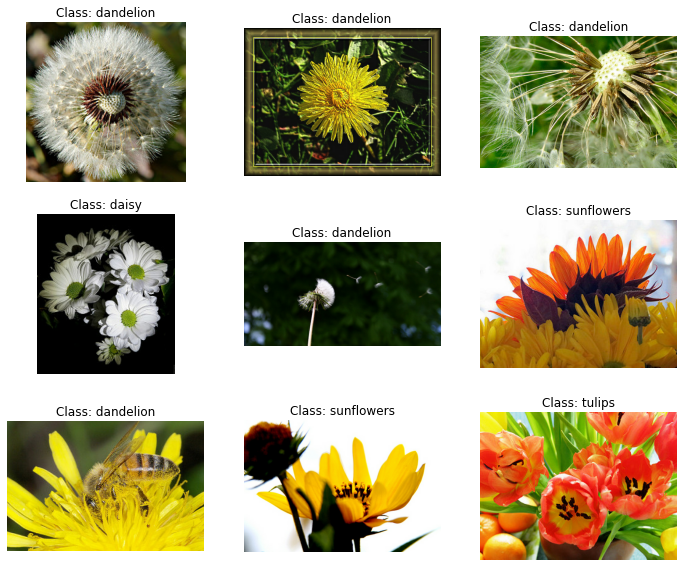

In [98]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

# 画一些花朵看一下
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()


### 5.2 数据预处理

数据预处理的2个核心步骤，一是resize成模型要求的输入大小，然后调用模型提供的preprocess_input()函数。

如果要执行一些数据增强，可以更改训练集的预处理功能，向训练图像添加一些随机变换。例如，使用tf.image.random_crop（）随机裁切图像，使用tf.image.random_flip_left_right（）随机水平翻转图像，以此类推（有关示例请参阅notebook的“PretrainedModelsforTransferLearning”部分）。


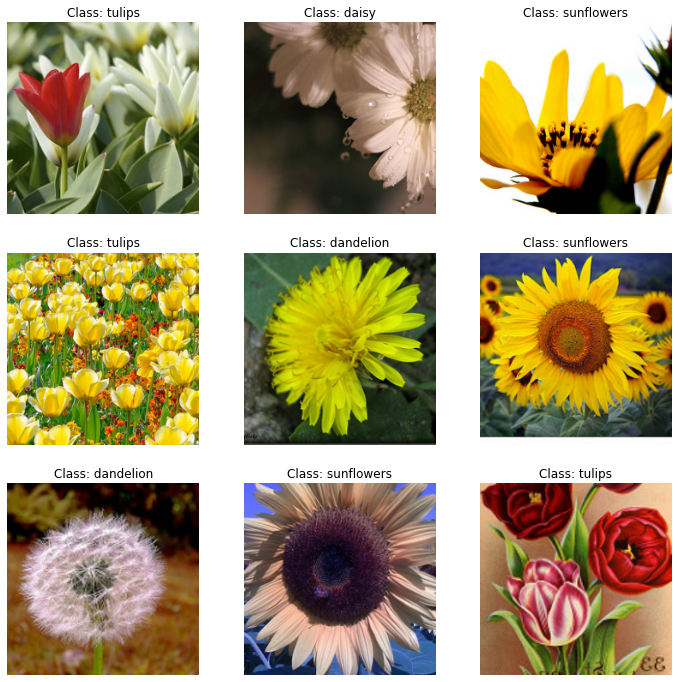

In [99]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

# 看一下train数据集：
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

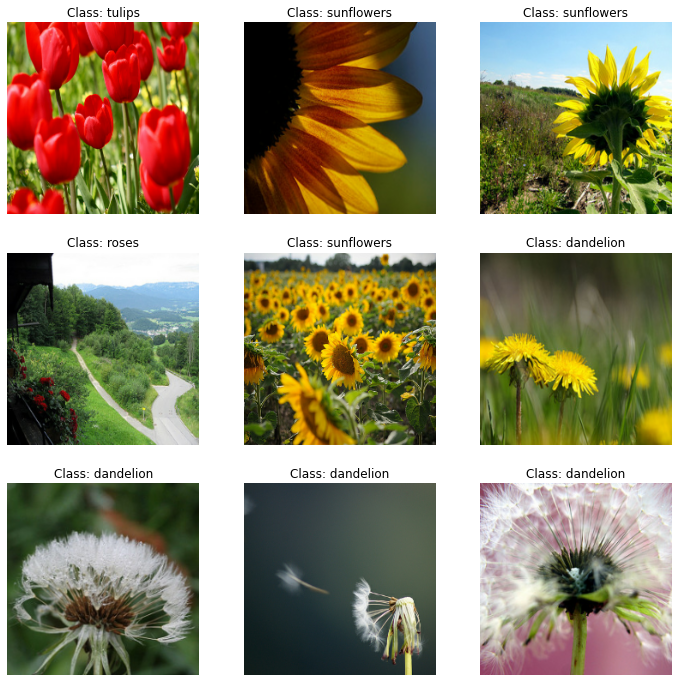

In [100]:
# 看一下test数据集
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

### 5.3 加载模型、删除并自定义顶层

In [101]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [102]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_13
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_45
13 block2_pool
14 batch_normalization_16
15 add_48
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_46
23 block3_pool
24 batch_normalization_17
25 add_49
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_47
33 block4_pool
34 batch_normalization_18
35 add_50
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_51
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 bl

### 5.4 冻结顶层、训练模型

In [103]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 46s 510ms/step - loss: 1.1122 - accuracy: 0.8089 - val_loss: 1.2033 - val_accuracy: 0.8309
Epoch 2/5
86/86 [==============================] - 45s 520ms/step - loss: 0.5298 - accuracy: 0.8914 - val_loss: 0.6784 - val_accuracy: 0.8621
Epoch 3/5
86/86 [==============================] - 43s 498ms/step - loss: 0.2988 - accuracy: 0.9266 - val_loss: 0.5861 - val_accuracy: 0.8897
Epoch 4/5
86/86 [==============================] - 44s 508ms/step - loss: 0.2184 - accuracy: 0.9397 - val_loss: 0.5899 - val_accuracy: 0.8732
Epoch 5/5
86/86 [==============================] - 44s 508ms/step - loss: 0.1620 - accuracy: 0.9509 - val_loss: 0.5366 - val_accuracy: 0.8934


### 5.5 解冻顶层，继续训练

In [105]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=2)

Epoch 1/2
86/86 [==============================] - 305s 4s/step - loss: 0.0367 - accuracy: 0.9866 - val_loss: 0.2273 - val_accuracy: 0.9210
Epoch 2/2
86/86 [==============================] - 301s 4s/step - loss: 0.0339 - accuracy: 0.9891 - val_loss: 0.2769 - val_accuracy: 0.9118


## 6、分类与定位

In [106]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [107]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [108]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 23s 4s/step - loss: 1.3225 - dense_20_loss: 1.5600 - dense_21_loss: 0.3722 - dense_20_accuracy: 0.3063 - dense_21_accuracy: 0.2188
Epoch 2/2
5/5 [==============================] - 17s 3s/step - loss: 1.0969 - dense_20_loss: 1.3200 - dense_21_loss: 0.2043 - dense_20_accuracy: 0.5875 - dense_21_accuracy: 0.2500


### Mean Average Precision (mAP)

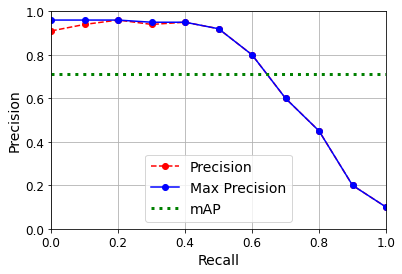

In [109]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

In [110]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

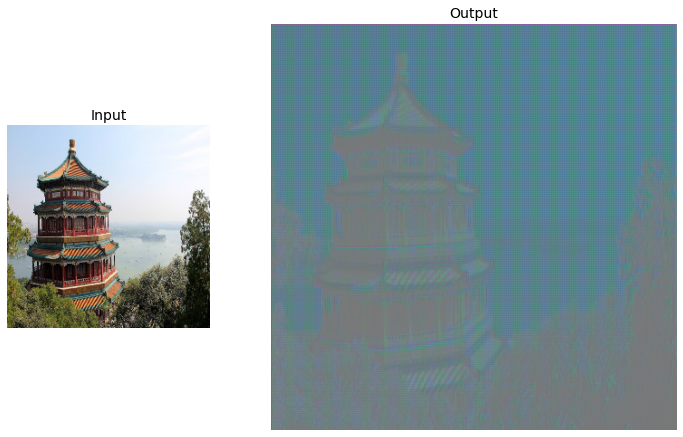

In [111]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [112]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [113]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

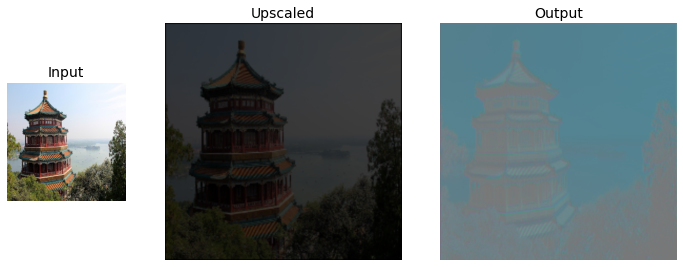

In [114]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

## 7、用keras实现ResNet-34 CNN